### Лабораторная работа 1-3 
### Лосева Н. Вариант 2. Economics of Cities

In [29]:
#  Активируем библиотеки

import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import metrics


In [2]:
#  Задаем рабочую папку
os.chdir("C:/Users/User/Desktop/python_analysis/lab1_ierarh/")

#  Импорт данных
df = pd.read_csv("Econom_Cities_data.csv", sep=";", index_col='City')

**Предобработка данных**

In [3]:
# Проверка нулевых значений 
df.isnull().sum()

Work      0
Price     0
Salary    0
dtype: int64

In [4]:
#Проверка типов данных столбцов
df.dtypes

Work       int64
Price     object
Salary    object
dtype: object

In [5]:
# Замена запятых на точки, чтобы преобразовать столбцы в числовые значения
df['Work'] = df['Work'].replace(',', '.', regex=True)  
df['Price'] = df['Price'].replace(',', '.', regex=True)
df['Salary'] = df['Salary'].replace(',', '.', regex=True)

# Преобразования в числовые значения 
df['Work'] = pd.to_numeric(df['Work'], errors='coerce')  
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce') 

In [6]:
# Просмотр описательной статистики датафрейма
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Как видно из описательной статистика: 
- Переменные измеряются в разных единицах
- Cтандартное отклонение для Work и Salary указывает на большую вариативность данных. Это может повлиять на кластеризацию.
- Наличие выбросов (судя по минимальному значению Salary)
 
Судя по написанным выше фактам стоит провести стандартизацию даннных, для устранения влияния различных шшкал и единиц измерения. Но перед этим нужно сделать прверку на выборсы и исключить их при необходимости. 

In [20]:
# Применение Z-score для поиска выбросов
z_scores = np.abs(stats.zscore(df[['Work', 'Price', 'Salary']]))  # Рассчитываем z-оценки
outliers = (z_scores > 3)  # Выбросы при |z| > 3

# Вывод выбросов
print('Выбросы:')
print(df[outliers.any(axis=1)])

Выбросы:
         Work  Price  Salary  cluster
City                                 
Cairo   -9999   37.1 -9999.0        1
Jakarta -9999   43.6 -9999.0        1


In [21]:
# Исклюючаем выбросы
df = df[(z_scores < 3).all(axis=1)]

Используем ящик с усами для проверки выбросов после исключения

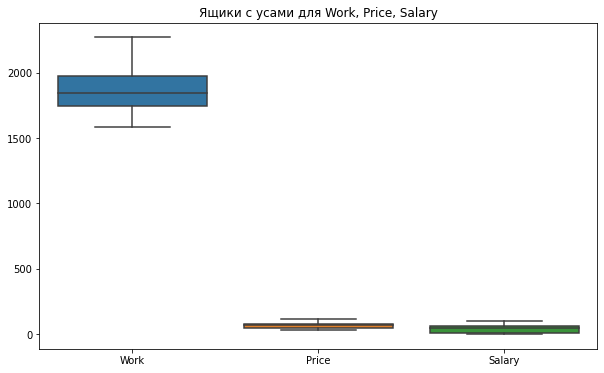

In [22]:
# Построение графиков с усами для столбцов Work, Price, Salary
plt.figure(figsize=(10, 6))

# Построение боксплота для всех числовых столбцов
sns.boxplot(data=df[['Work', 'Price', 'Salary']])

# Показ графика
plt.title('Ящики с усами для Work, Price, Salary')
plt.show()

В столбце work все равно присутвует выброс с максимальным значениям, которые выходит за пределеы "усов"

In [8]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


In [9]:
df = df[df['Work'] != 2375]

После того, как мы исключили выбросы проведем стандартизацию данных

In [10]:
df.index = df.index.astype(str)

In [25]:
from sklearn import preprocessing

# Выбираем один из вариантов стандартизации
stand_1 = preprocessing.StandardScaler()
#stand_1 = preprocessing.MaxAbsScaler()

# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
stand_1.fit(df)
# преобразуем данные
X = stand_1.transform(df)
# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
X = pd.DataFrame(X, index=df.index, columns=df.columns)

In [26]:
X.head()

,Work,Price,Salary,cluster
City,,,,
Amsterdam,-0.983144,-0.217146,0.372285,1.156703
Athens,-0.488117,-0.769372,-0.380924,-0.884538
Bogota,1.796625,-1.513472,-1.146282,-1.905159
Bombay,1.161975,-1.869142,-1.397352,0.136083
Brussels,-1.021223,0.166604,0.433028,1.156703


**Иерархический кластерный анализ**

In [13]:
#  Активируем 3 процедуры иерархического кластерного анализа
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [14]:
X.index.tolist()

['Amsterdam',
 'Athens',
 'Bogota',
 'Bombay',
 'Brussels',
 'Buenos_Aires',
 'Cairo',
 'Caracas',
 'Chicago',
 'Copenhagen',
 'Dublin',
 'Dusseldorf',
 'Frankfurt',
 'Geneva',
 'Helsinki',
 'Houston',
 'Jakarta',
 'Johannesburg',
 'Kuala_Lumpur',
 'Lagos',
 'Lisbon',
 'London',
 'Los_Angeles',
 'Luxembourg',
 'Madrid',
 'Manila',
 'Mexico_City',
 'Milan',
 'Montreal',
 'Nairobi',
 'New_York',
 'Nicosia',
 'Oslo',
 'Panama',
 'Paris',
 'Rio_de_Janeiro',
 'San_Paulo',
 'Seoul',
 'Singpore',
 'Stockholm',
 'Sydney',
 'Taipei',
 'Tel_Aviv',
 'Tokyo',
 'Toronto',
 'Vienna',
 'Zurich']

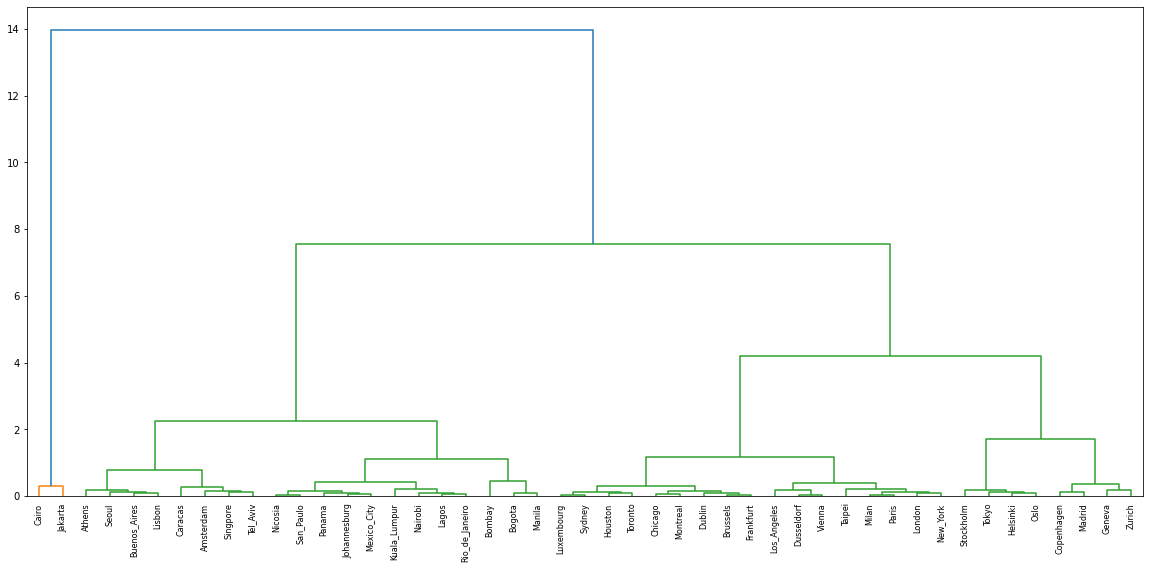

In [15]:
#  Кластеризуем и строим дендрограмму
link = linkage(X, 'ward', 'euclidean')
fig = plt.figure(figsize=(20,9))
dn = dendrogram(link, labels= df.index.tolist())

Так у нас получается 2 кластера. Но если мы поставим порогое значения равное 3.1, то у нас будет уже больше кластеров

Text(0, 0.5, 'Расстояние')

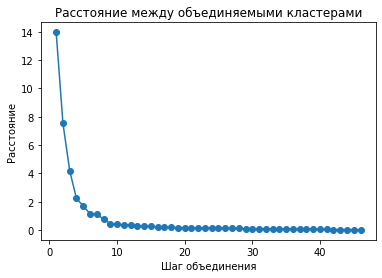

In [16]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')

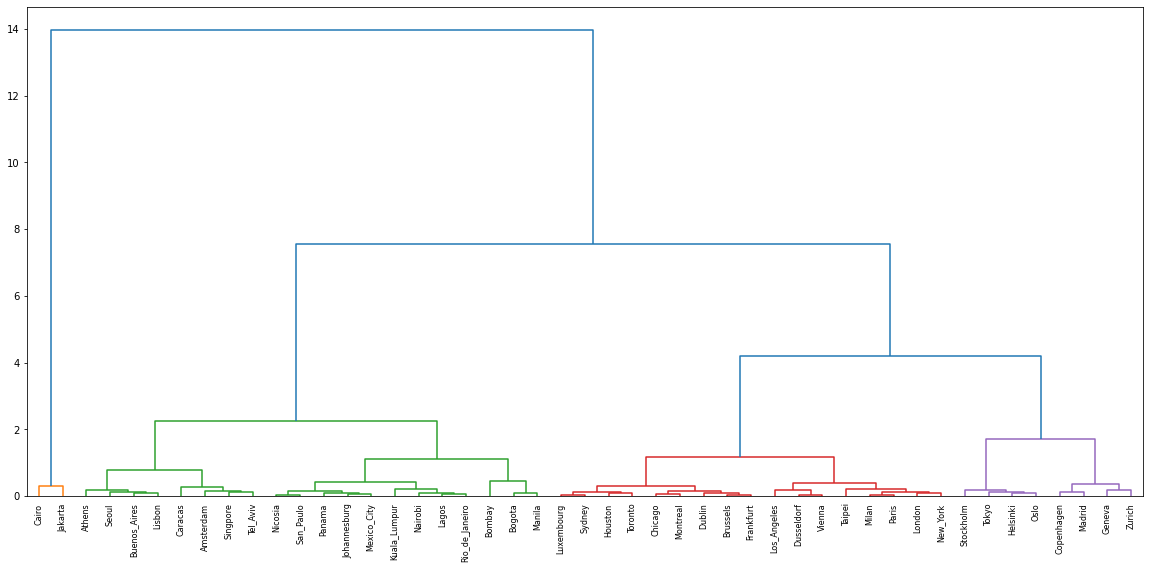

In [17]:
fig = plt.figure(figsize=(20,9))
dn = dendrogram(link, color_threshold = 3.1, labels=df.index.tolist())

Здесь у нас значение кластеров уже 5. Добавим столбец с номером кластера и посмотрим распределения на графике.

In [288]:
df_1 = df.copy()
df_2 = df.copy()

In [289]:
df_1['cluster'] = fcluster(link, 2, criterion='maxclust')
df_2['cluster'] = fcluster(link, 4, criterion='maxclust')

C:\Users\User\AppData\Local\Temp\ipykernel_10656\3482072333.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Кластер')
C:\Users\User\AppData\Local\Temp\ipykernel_10656\3482072333.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Кластер')


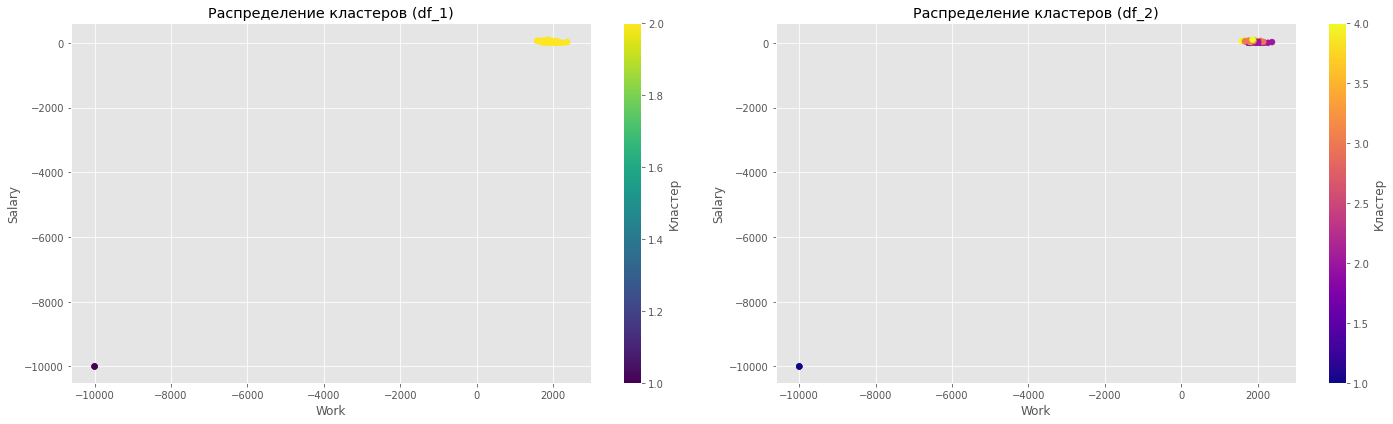

In [290]:
plt.figure(figsize=(20, 6))

# Первый график
plt.subplot(1, 2, 1) 
plt.scatter(df_1['Work'], df_1['Salary'], c=df_1['cluster'], cmap='viridis')
plt.xlabel('Work')
plt.ylabel('Salary')
plt.title('Распределение кластеров (df_1)')
plt.colorbar(label='Кластер')

# Второй график
plt.subplot(1, 2, 2)  
plt.scatter(df_2['Work'], df_2['Salary'], c=df_2['cluster'], cmap='plasma')
plt.xlabel('Work')
plt.ylabel('Salary')
plt.title('Распределение кластеров (df_2)')
plt.colorbar(label='Кластер')


plt.tight_layout()
plt.show()

Как видно из графиков распределение правом графике лучше, так как унего почти нет пересечения 
На левом грифике есть переесечения 

In [ ]:
df_3 = df.copy()
df_3['cluster'] = fcluster(link, 6, criterion='maxclust')

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(df_3['Work'], df_3['Salary'], c=df_3['cluster'], cmap='plasma')
plt.xlabel('Work')
plt.ylabel('Salary')
plt.title('Распределение кластеров (df_2)')
plt.colorbar(label='Кластер')

### Кластеризация

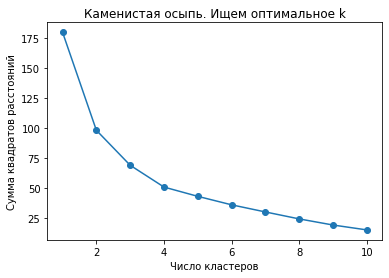

In [27]:
K = range(1, 11)

# Вычисляем значения критерия качества для разного числа кластеров
models = [KMeans(n_clusters=k, random_state=42).fit(X) for k in K]
dist = [model.inertia_ for model in models]

# Строим график каменистая осыпь
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное k')
plt.show()

In [24]:
# Строим модель
model = KMeans(n_clusters=4, random_state=42, max_iter=300, n_init=10, verbose=0)
model.fit(X)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,2183.000000,51.425000,14.975000
1,1830.923077,75.323077,47.830769
2,1996.769231,60.238462,27.715385
3,1707.266667,79.520000,49.953333


###  Кластеризация методом DBSCAN  

In [30]:
eps_1 = [0.95, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
min_samples_1 = [2, 3, 4, 5, 10, 15, 20, 25]

In [31]:
sil_avg = []

#  Для сохранения наилучшено набора параметров
max_value = [0, 0, 0, -1]

In [32]:
#  Перебираю все пары значений параметров
#  Сохраняю лучшее решение

for i in range(len(eps_1)):
    for j in range(len(min_samples_1)):

        db = DBSCAN(min_samples = min_samples_1[j], eps =eps_1[i]).fit(X)
        
        labels = db.labels_

        # Число кластеров, после отбрасывания выбросов.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Число выбросов.
        # n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:
            silhouette_avg = metrics.silhouette_score(df, labels)
            if silhouette_avg > max_value[3]:
                max_value=(eps_1[i], min_samples_1[j], n_clusters_, silhouette_avg)
            sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 1.5 
min_sample= 2 
number of clusters= 2 
average silhouette score= 0.3359


In [38]:
# Запуск кластеризации с подобранными параметрами
dbscan_4 = DBSCAN(eps=max_value[0], metric='euclidean', min_samples=max_value[1], algorithm= 'brute')

dbscan_4.fit(X)

unique, counts = np.unique(dbscan_4.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1  1]
 [ 0 41]
 [ 1  3]]


In [39]:
# Попытка скорректировать
dbscan_4 = DBSCAN(eps=1.4, metric='euclidean', min_samples=2)

dbscan_4.fit(X)

unique, counts = np.unique(dbscan_4.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1  1]
 [ 0 15]
 [ 1 22]
 [ 2  3]
 [ 3  4]]
